## 01_Prédire le temps de course restant
Ce notebook vise à prédire le temps restant d'une course à partir des mesures : 
- la distance parcourue, 
- la vitesse,
- la fréquence cardiaque,
- et la distance totale de course 
à un instant t.

On utilise pour cela un Echo State Network (ESN).

Nous importons NumPy, Pandas et Matplotlib pour le traitement des données et la visualisation. ReservoirPy fournit l'implémentation de l'ESN via les nœuds `Reservoir` et `Ridge`. 
Les modules `glob` et `re` servent à lister les fichiers CSV et à extraire les indices de course depuis leur nom.

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import reservoirpy as rpy
from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy import ESN
import glob
import re

In [2]:
# Fixer la graine pour reproductibilité
rpy.set_seed(42)

### Préparation des données d'entraînement
Nous chargeons les fichiers CSV des différentes courses et construisons un ensemble d'entraînement. 

On choisi pour entrainement les courses 4 à 10 et on garde les autres courses pour la phase de test. 

Le temps est converti en secondes écoulées et à partir de là, nous dérivons `time_remaining` comme la différence entre le temps total et le temps déjà écoulé. Nous conservons aussi `km_total` pour connaitre la distance totale de la course.

On créé ensuite des paire X(t) -> Y(t+dt) pour permettre l'apprentissage de la prédiction. 

In [3]:
# Chargement des données (courses 4 à 10 pour l'entraînement)
data_dir = "../projet_data/data"
files = glob.glob(f"{data_dir}/course*.csv")

def course_idx(path):
    m = re.search(r"course(\d+)\.csv", path)
    return int(m.group(1)) if m else 1e9

files = sorted(files, key=course_idx)
train_files = files[3:10]
print("Fichiers d'entraînement:", [f.split("/")[-1] for f in train_files])

X_train_list_raw = []
y_train_list_raw = []

for fp in train_files:
    df = pd.read_csv(fp, sep=';', decimal=',').fillna(0)
    df["Time"] = pd.to_datetime(df["Time"])
    df["t_elapsed"] = (df["Time"] - df["Time"].iloc[0]).dt.total_seconds()
    total_time = df["t_elapsed"].iloc[-1]
    df["time_remaining"] = total_time - df["t_elapsed"]
    km_total = df["km"].iloc[-1]
    df["km_total"] = km_total

    Xi = df[["km", "speed_kmh", "FC", "km_total"]].values
    yi = df["time_remaining"].values.reshape(-1, 1)

    # Paires t -> t+1 intra-course
    X_train_list_raw.append(Xi[:-1])
    y_train_list_raw.append(yi[1:])

print("Nombre de courses entraînement:", len(X_train_list_raw))

Fichiers d'entraînement: ['data\\course4.csv', 'data\\course5.csv', 'data\\course6.csv', 'data\\course7.csv', 'data\\course8.csv', 'data\\course9.csv', 'data\\course10.csv']
Nombre de courses entraînement: 7


### Normalisation des séquences
Avant l'entraînement, nous appliquons une normalisation simple 0–1 en divisant chaque variable par son maximum calculé sur l'ensemble d'entraînement, et la cible par son maximum global. Cela permet de standardiser les données sur toutes les courses.

In [4]:
# Normalisation  (0-1) sur l'ensemble d'entraînement
X_concat = np.vstack(X_train_list_raw)
y_concat = np.vstack(y_train_list_raw)

X_max = X_concat.max(axis=0)
y_max = y_concat.max()

Xn_train_list = [Xi / X_max for Xi in X_train_list_raw]
Yn_train_list = [yi / y_max for yi in y_train_list_raw]

### Définition du modèle ESN
Nous configurons l'architecture de l'ESN : un `Reservoir` de 100 unités avec un taux de fuite (`lr`) et un rayon spectral (`sr`). Le `Ridge` sert de readout linéaire régularisé.

Le pipeline `reservoir >> readout` indique que les états internes du réservoir alimentent la couche de sortie pour la prédiction.

In [5]:
# Création du réservoir
reservoir = Reservoir(units=100, lr=0.5, sr=0.9)
readout = Ridge(ridge=1e-7)
esn_model = reservoir >> readout


### Entraînement avec période de warmup
Nous entraînons le modèle sur les séquences normalisées en utilisant une période de `warmup` pour laisser le réservoir se stabiliser avant d'ajuster le readout. L'appel à `fit` parcourt chaque séquence et apprend une régression des états internes vers la cible.

In [6]:
# Entraînement sur listes de séquences
warmup = 20
esn_model = esn_model.fit(Xn_train_list, Yn_train_list, warmup=warmup)

print("Reservoir initialized:", reservoir.initialized)
print("Readout initialized:", readout.initialized)

Reservoir initialized: True
Readout initialized: True


### Prétraitement et inférence sur la course de test
Pour l'évaluation, nous sélectionnons une course de test non vue et reproduisons le même prétraitement que pour l'entraînement. Nous normalisons les entrées à l'aide des maxima calculés sur l'entraînement.

Après `reset()` pour réinitialiser l'état du modèle, nous utilisons `run` pour produire des prédictions normalisées, puis nous les re-projetons à l'échelle réelle pour comparer au temps restant réel.

In [7]:
# Prédiction sur une course de test (non vue)
# Utilise la 12e course 
test_file = files[11] if len(files) > 8 else train_files[-1]
print("Fichier de test:", test_file.split("/")[-1])

test_df = pd.read_csv(test_file, sep=';', decimal=',').fillna(0)
test_df["Time"] = pd.to_datetime(test_df["Time"])
test_df["t_elapsed"] = (test_df["Time"] - test_df["Time"].iloc[0]).dt.total_seconds()
total_time_test = test_df["t_elapsed"].iloc[-1]
test_df["time_remaining"] = total_time_test - test_df["t_elapsed"]
km_total_test = test_df["km"].iloc[-1]
test_df["km_total"] = km_total_test

X_test_raw = test_df[["km", "speed_kmh", "FC", "km_total"]].values
y_test_raw = test_df["time_remaining"].values.reshape(-1, 1)

X_test_n = X_test_raw / X_max
y_test_n = y_test_raw / y_max

esn_model.reset()
y_pred_n = esn_model.run(X_test_n)

y_pred = y_pred_n * y_max
y_real = y_test_n * y_max

Fichier de test: data\course12.csv


Nous traçons le temps restant réel et celui prédit pour la course choisie. Les premiers points de warmup sont ignorés (moins fiables).

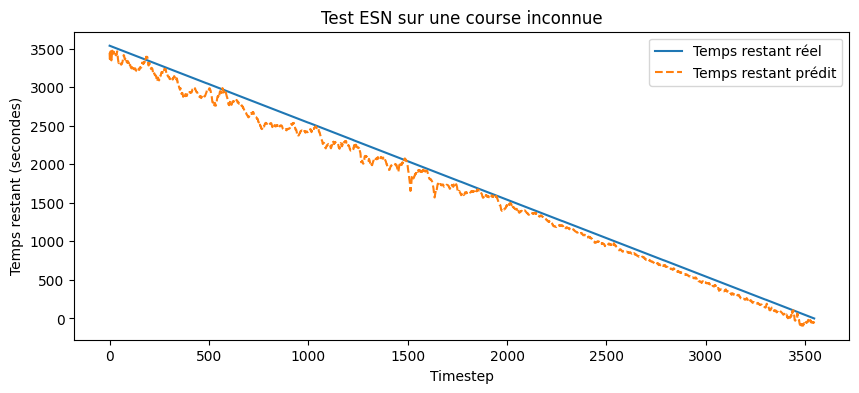

In [8]:
# Visualisation
skip = warmup  # nombre de points à ignorer

plt.figure(figsize=(10,4))
plt.plot(y_real[skip:], label="Temps restant réel")
plt.plot(y_pred[skip:], "--", label="Temps restant prédit")
plt.xlabel("Timestep")
plt.ylabel("Temps restant (secondes)")
plt.title(
    "Test ESN sur une course inconnue"
    if test_file not in train_files
    else "Démo ESN sur course d'entraînement"
)
plt.legend()
plt.show()

### Analyse 
On voit que le modèle semble bien prédire le temps restant de course à chaque instant. Cela pourrait être utile pour un entraineur qui supervise une course, ou bien pour implémenter un feedback sur la montre connectée d'un coureur. 

Il s'agit en revanche d'une donnée monotone décroissante avec peu de variation à court terme, donc cela n'a pas trop d'intéret à etre prédit par l'ESN et un modèle plus simple peut suffire si le signal est quasi régulier.

Nous nous sommes donc penchées sur une autre prédiction reposant sur des data plus archaiques et à des échelles de prédiction plus cohérentes (cf. notebook 02).